<a href="https://colab.research.google.com/github/darockz659/ideal-octo-giggle/blob/master/C5_A_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PREREQUISITES**

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
#from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
from PIL import Image
from keras import backend, optimizers
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS.zip'

Streaming output truncated to the last 5000 lines.
  inflating: archive/OUHANDS_train/train/negative_data/colour/1825.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1826.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1827.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1828.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1829.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1830.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1831.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1832.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1833.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1834.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1835.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1836.png  
  inflating: archive/OUHANDS_train/train/negative_data/colour/1837.png  


**DATA** **LOADER**

In [ ]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [ ]:
path = '/content/archive/OUHANDS_train/train/hand_data/colour'

maskpath ='/content/archive/OUHANDS_train/train/hand_data/segmentation'

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))

print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:04<00:00, 466.50it/s]


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

**SEGMENTATION** **MODEL**

In [ ]:
def conv_block(x, filter_size, size, dropout=0.1, batch_norm=True):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [ ]:
def gating_signal(input, out_size, batch_norm=True):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.1, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 16 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    # conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    # gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    # att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    # up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    # up_16 = layers.concatenate([up_16, att_16], axis=3)
    # up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    
    model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Model Checkpoint_rgb
checkpoint_path_recog = "/content/drive/MyDrive/OUHANDS/C5checkp.ckpt"
model_checkpoint_recog = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_recog,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [ ]:
model = Attention_UNet(input_shape, 1, 0.1, True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.load_weights(checkpoint_path_recog)

In [ ]:
OUTPUT = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=2,epochs=20,callbacks=[model_checkpoint_recog])

Epoch 1/20
900/900 [==============================] - 163s 140ms/step - loss: 0.3879 - accuracy: 0.9468 - val_loss: 0.2728 - val_accuracy: 0.9609

Epoch 00001: val_accuracy improved from -inf to 0.96087, saving model to /content/drive/MyDrive/OUHANDS/C5checkp.ckpt
Epoch 2/20
900/900 [==============================] - 124s 138ms/step - loss: 0.1980 - accuracy: 0.9726 - val_loss: 0.1493 - val_accuracy: 0.9749

Epoch 00002: val_accuracy improved from 0.96087 to 0.97494, saving model to /content/drive/MyDrive/OUHANDS/C5checkp.ckpt
Epoch 3/20
900/900 [==============================] - 125s 139ms/step - loss: 0.1224 - accuracy: 0.9787 - val_loss: 0.1194 - val_accuracy: 0.9708

Epoch 00003: val_accuracy did not improve from 0.97494
Epoch 4/20
900/900 [==============================] - 125s 139ms/step - loss: 0.0871 - accuracy: 0.9807 - val_loss: 0.0737 - val_accuracy: 0.9800

Epoch 00004: val_accuracy improved from 0.97494 to 0.98005, saving model to /content/drive/MyDrive/OUHANDS/C5checkp.ck

Text(0, 0.5, 'Training Error')

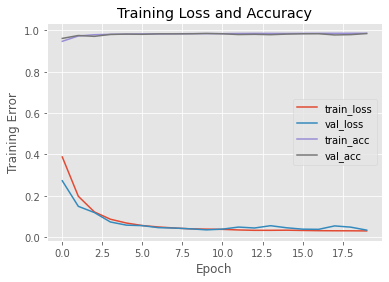

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), OUTPUT.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), OUTPUT.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), OUTPUT.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0,N), OUTPUT.history["val_accuracy"], label = "val_acc")
plt.legend(loc="center right")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [ ]:
pred_train=model.predict(X_train[:int(X_train.shape[0])],verbose=1)

pred_train_t = (pred_train>0.5).astype(np.uint8)

63/63 [==============================] - 66s 460ms/step


In [ ]:
for i in range(pred_train_t.shape[0]):
  name="seg"+str(i)+".jpg"
  img=np.reshape(pred_train_t[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
for i in range(pred_train_t.shape[0]):
  name="mask"+str(i)+".jpg"
  img=np.reshape(Y_train[i],(IMG_HEIGHT,IMG_WIDTH))
  img=255*img
  cv2.imwrite(name,img)

In [ ]:
!ls

archive       mask15.jpg    mask400.jpg  seg1000.jpg  seg1602.jpg  seg403.jpg
drive	      mask1600.jpg  mask401.jpg  seg1001.jpg  seg1603.jpg  seg404.jpg
mask0.jpg     mask1601.jpg  mask402.jpg  seg1002.jpg  seg1604.jpg  seg405.jpg
mask1000.jpg  mask1602.jpg  mask403.jpg  seg1003.jpg  seg1605.jpg  seg406.jpg
mask1001.jpg  mask1603.jpg  mask404.jpg  seg1004.jpg  seg1606.jpg  seg407.jpg
mask1002.jpg  mask1604.jpg  mask405.jpg  seg1005.jpg  seg1607.jpg  seg408.jpg
mask1003.jpg  mask1605.jpg  mask406.jpg  seg1006.jpg  seg1608.jpg  seg409.jpg
mask1004.jpg  mask1606.jpg  mask407.jpg  seg1007.jpg  seg1609.jpg  seg40.jpg
mask1005.jpg  mask1607.jpg  mask408.jpg  seg1008.jpg  seg160.jpg   seg410.jpg
mask1006.jpg  mask1608.jpg  mask409.jpg  seg1009.jpg  seg1610.jpg  seg411.jpg
mask1007.jpg  mask1609.jpg  mask40.jpg	 seg100.jpg   seg1611.jpg  seg412.jpg
mask1008.jpg  mask160.jpg   mask410.jpg  seg1010.jpg  seg1612.jpg  seg413.jpg
mask1009.jpg  mask1610.jpg  mask411.jpg  seg1011.jpg  seg1613.jpg  s

In [ ]:
X_train.shape

(2000, 320, 320, 3)

In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
path = "/content/archive/OUHANDS_test/test/hand_data/colour"
maskpath = "/content/archive/OUHANDS_test/test/hand_data/segmentation"

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:02<00:00, 429.44it/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [ ]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

In [ ]:
 #    ######evaluate#####
model.load_weights(checkpoint_path_recog)
y_pred=model.predict(X_test)
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9654154882812507


Text(0.5, 1.0, 'TEST IMAGE')

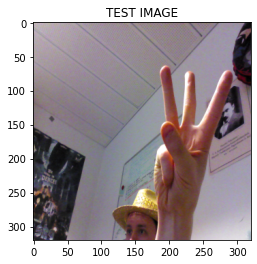

In [ ]:
plt.imshow(array_to_img(X_test[420]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

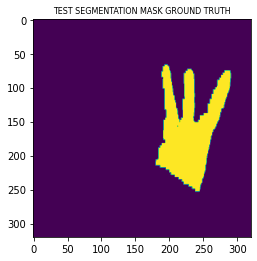

In [ ]:
plt.imshow(array_to_img(Y_test[420]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

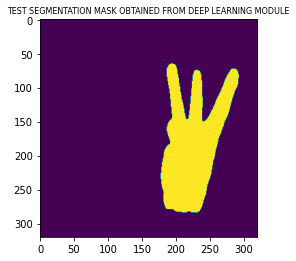

In [ ]:
plt.imshow(array_to_img(y_pred[420]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
x_test_single = np.expand_dims(X_test[7], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.840958833694458 seconds ---
